### Case 4B - Offshore windfarm - AC Substation - AC Collection cable
This notebook shows the basics of Case 4b as suggested by Noor Abrahamse:

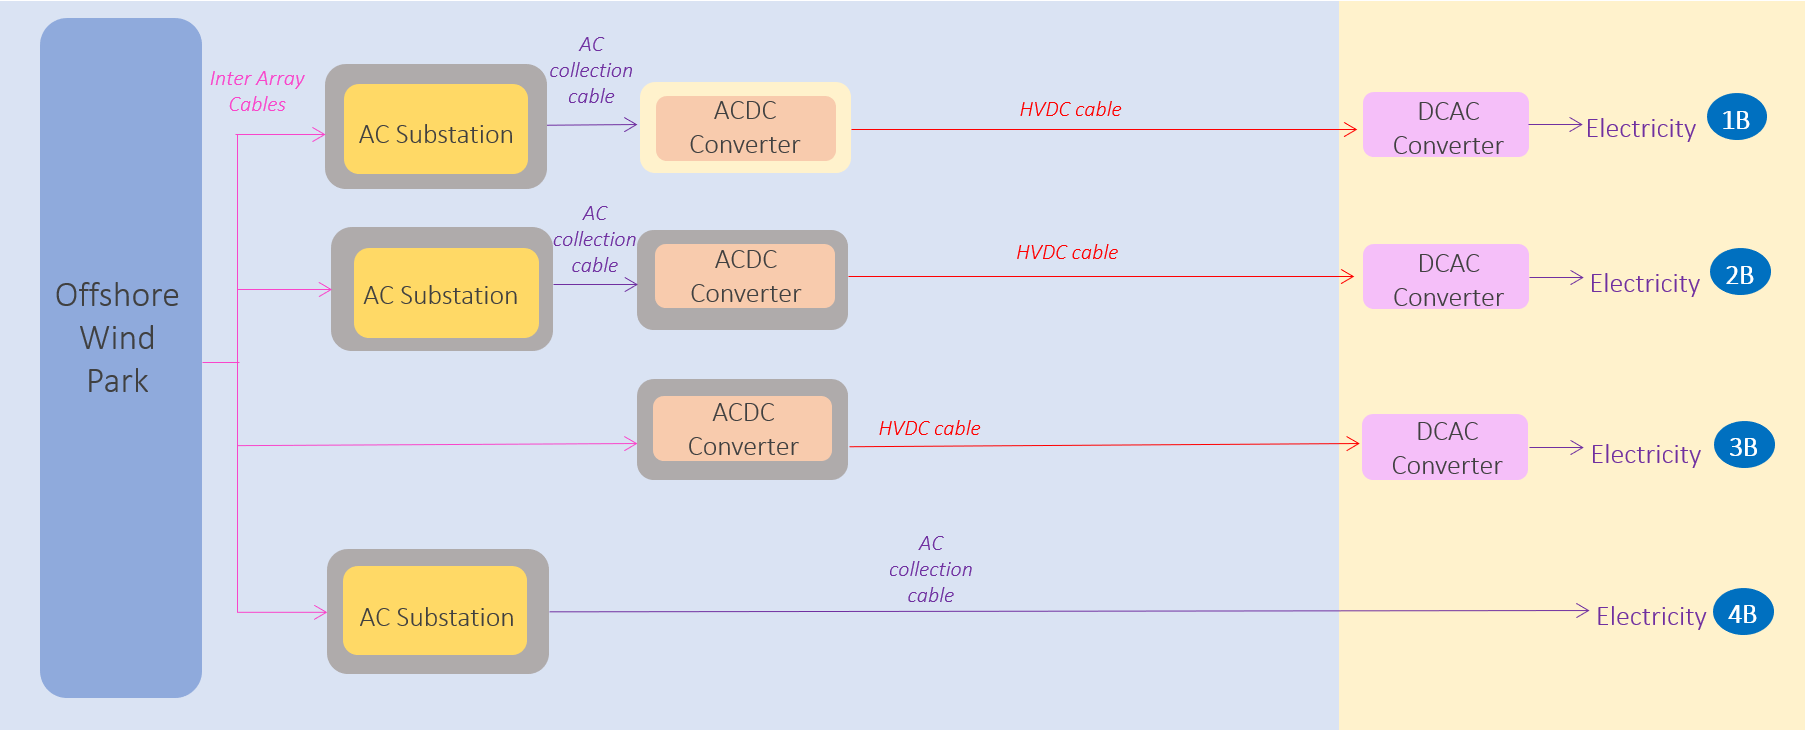

#### 0. Import basic methods (a.o. from source2.py)

In [1]:
from source2 import *
import folium
import numpy as np
import matplotlib.pyplot as plt

import pyproj
import shapely.geometry
from shapely.geometry.base import BaseGeometry

In [2]:
# load basic info from the Input sheet
mapping = load_input_from_xls(filename=r'H2 Model - Input sheet.xlsm')
Inputs = extract_scenario(mapping, 'Scenario1')

##### 1. prepare input data and generate objects

In [3]:
foundation_data = get_object_data(Inputs=Inputs, 
                               subsystem='Wind energy source & Transport', 
                               element='Offshore wind park',
                               component='Foundation & cable')
display(foundation_data)

turbine_data = get_object_data(Inputs=Inputs, 
                               subsystem='Wind energy source & Transport', 
                               element='Offshore wind park',
                               component='Turbine')
display(turbine_data)

AC_substation_data = get_object_data(Inputs=Inputs, 
                               subsystem='AC Substation & Transport', 
                               element='AC Substation & Transport',
                               component='AC Substation')
display(AC_substation_data)

AC_collection_cable_data = get_object_data(Inputs=Inputs, 
                               subsystem='AC Substation & Transport', 
                               element='AC Substation & Transport',
                               component='AC collection cable')
display(AC_collection_cable_data)

issue detected


{'sub_system': 'Wind energy source & Transport',
 'element': 'Offshore wind park',
 'component': 'Foundation & cable',
 'escalation_base_year': 2023,
 'escalation_rate': 0.02,
 'capex_per_unit': 2691000,
 'capex_per_unit_units': 'EUR / MW',
 'unit': 3000,
 'unit_units': 'MW',
 'construction_duration': 1,
 'share_of_investments': [1, 0, 0],
 'economic_lifetime': 30,
 'depreciation_flag': 1,
 'depreciation_rate': [],
 'yearly_variable_costs_flag': 1,
 'yearly_variable_costs_rate': 0.03,
 'insurance_flag': 1,
 'insurance_rate': 0.005,
 'decommissioning_rate': 0.02,
 'residual_value': 0.01}

issue detected


{'sub_system': 'Wind energy source & Transport',
 'element': 'Offshore wind park',
 'component': 'Turbine',
 'escalation_base_year': 2023,
 'escalation_rate': 0.02,
 'capex_per_unit': 1495000,
 'capex_per_unit_units': 'EUR / MW',
 'unit': 3000,
 'unit_units': 'MW',
 'construction_duration': 2,
 'share_of_investments': [0.4, 0.6, 0],
 'economic_lifetime': 30,
 'depreciation_flag': 1,
 'depreciation_rate': [],
 'yearly_variable_costs_flag': 1,
 'yearly_variable_costs_rate': 0.03,
 'insurance_flag': 1,
 'insurance_rate': 0.005,
 'decommissioning_rate': 0.02,
 'residual_value': 0.01}

issue detected


{'sub_system': 'AC Substation & Transport',
 'element': 'AC Substation & Transport',
 'component': 'AC Substation',
 'escalation_base_year': 2023,
 'escalation_rate': 0.02,
 'capex_per_unit': 195000,
 'capex_per_unit_units': 'EUR / MW',
 'unit': 3000,
 'unit_units': 'MW',
 'construction_duration': 2,
 'share_of_investments': [0.8, 0.2, 0],
 'economic_lifetime': 40,
 'depreciation_flag': 1,
 'depreciation_rate': [],
 'yearly_variable_costs_flag': 1,
 'yearly_variable_costs_rate': 0.02,
 'insurance_flag': 1,
 'insurance_rate': 0.005,
 'decommissioning_rate': 0.02,
 'residual_value': 0.01}

issue detected


{'sub_system': 'AC Substation & Transport',
 'element': 'AC Substation & Transport',
 'component': 'AC collection cable',
 'escalation_base_year': 2023,
 'escalation_rate': 0.02,
 'capex_per_unit': 350000,
 'capex_per_unit_units': 'EUR / m',
 'unit': 20000,
 'unit_units': 'm',
 'construction_duration': 2,
 'share_of_investments': [0.6, 0.4, 0],
 'economic_lifetime': 40,
 'depreciation_flag': 1,
 'depreciation_rate': [],
 'yearly_variable_costs_flag': 1,
 'yearly_variable_costs_rate': 0.02,
 'insurance_flag': 1,
 'insurance_rate': 0.005,
 'decommissioning_rate': 0.02,
 'residual_value': 0.01}

In [4]:
lifecycle = 30
Turbine = Object(**turbine_data)
Foundation = Object(**foundation_data)
ACStation = Object(**AC_substation_data)
ACCollectionCable = Object(**AC_collection_cable_data)

##### 2. generate cashflows

In [5]:
Turbine.generate_cashflows(startyear=2023, lifecycle=lifecycle, debug=False)
Foundation.generate_cashflows(startyear=2023, lifecycle=lifecycle, debug=False)
ACStation.generate_cashflows(startyear=2023, lifecycle=lifecycle, debug=False)
ACCollectionCable.generate_cashflows(startyear=2023, lifecycle=lifecycle, debug=False)

##### 3. combine cashflows and add revenues

In [6]:
total_wind_energy_production = 3000 * 1000 * 4380 * 30 # parkcapacity * operational hours * operational lifecycle
print('total_wind_energy_production: {:.0f} kWh'.format(total_wind_energy_production))
energy_after_inter_array_cable_loss = 0.98 * total_wind_energy_production
print('energy_after_inter_array_cable_loss (20 km): {:.0f} kWh'.format(energy_after_inter_array_cable_loss))
energy_after_AC_collection_cable_loss = 0.98 * energy_after_inter_array_cable_loss
print('energy_after_AC_collection_cable_loss (20 km): {:.0f} kWh'.format(energy_after_AC_collection_cable_loss))

total_wind_energy_production: 394200000000 kWh
energy_after_inter_array_cable_loss (20 km): 386316000000 kWh
energy_after_AC_collection_cable_loss (20 km): 378589680000 kWh


In [7]:
# ToDo: escalate the revenue values
df_combined=combine_cashflow_dataframes([Foundation.df, Turbine.df, ACStation.df])
df_combined.revenue = 0.1 * energy_after_AC_collection_cable_loss
for i in range(3):
    df_combined.loc[2023+i, 'revenue'] = 0

##### 4. calculate NPVs

In [8]:
df_combined_npv=calculate_npv(df_combined, 2023, WACC=0.0984)

##### 5. plot

###### 5.1 NPV plot

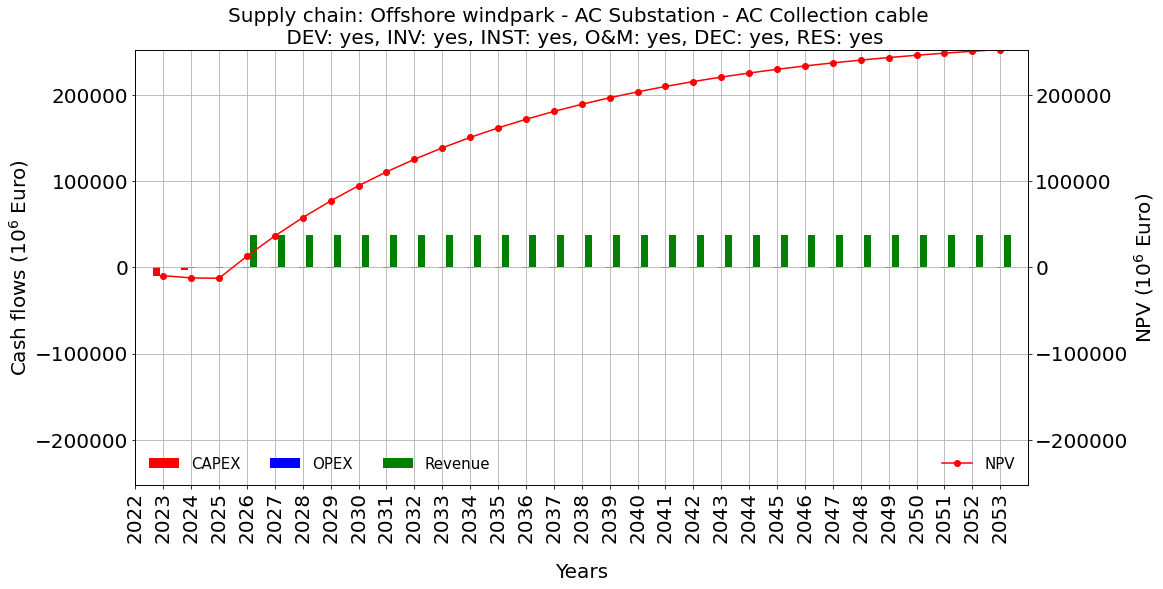

In [9]:
# DEV: Project development costs
# INV: Investment / procurement costs
# INST: Installation / construction costs 
# O&M: Yearly variable / O&M costs 
# DEC: Decommissioning costs 
# RES: Residual value   

create_npv_plot(df_combined_npv, title='Supply chain: Offshore windpark - AC Substation - AC Collection cable \n DEV: yes, INV: yes, INST: yes, O&M: yes, DEC: yes, RES: yes' )

###### 5.2 PIE plot

In [10]:
# collect the npv calculations per item (without revenues)
Turbine.df_npv = calculate_npv(Turbine.df, 2023, WACC=0.0984)
Foundation.df_npv = calculate_npv(Foundation.df, 2023, WACC=0.0984)
ACStation.df_npv = calculate_npv(ACStation.df, 2023, WACC=0.0984)
ACCollectionCable.df_npv = calculate_npv(ACCollectionCable.df, 2023, WACC=0.0984)

In [11]:
# prepare input for pie plot
labels = ['Foundations & cables', 'Turbines', 'AC Station', 'AC collection cable']
data = [
    -Foundation.df_npv.cashflow_sum.iloc[-1],
    -Turbine.df_npv.cashflow_sum.iloc[-1],
    -ACStation.df_npv.cashflow_sum.iloc[-1],
    -ACCollectionCable.df_npv.cashflow_sum.iloc[-1]
]   

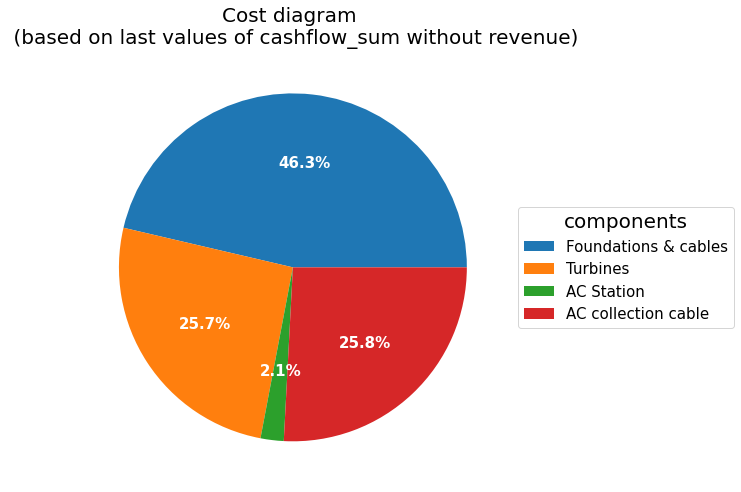

In [12]:
# create pie plot
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%"


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, labels,
          title="components",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
         fontsize=15)

plt.setp(autotexts, size=15, weight="bold")

ax.set_title("Cost diagram \n (based on last values of cashflow_sum without revenue)", fontsize=20)

plt.show()

##### 6. Calculate LCOE
NB: This is just an experiment, I am not entirely sure what is the precise way to calculate this (check!!)

Total windpark capacity * operational hours = Wind Energy Production per Year
3000 MW * 4380 h = 13.140.000 MWh 

Operational years * Production per year = Wind Energy Total Production
30 * 13.140.000 = 394.200.000 MWh 

Inter-array cable transport loss = 2%
Wind Energy to AC substation = (100 - 2%) * Wind Energy Total Production = 386.316.000 MWh 

AC collection cable transport loss = 2%

NB: shouldn't we try to estimate cable losses in % loss per km or so?

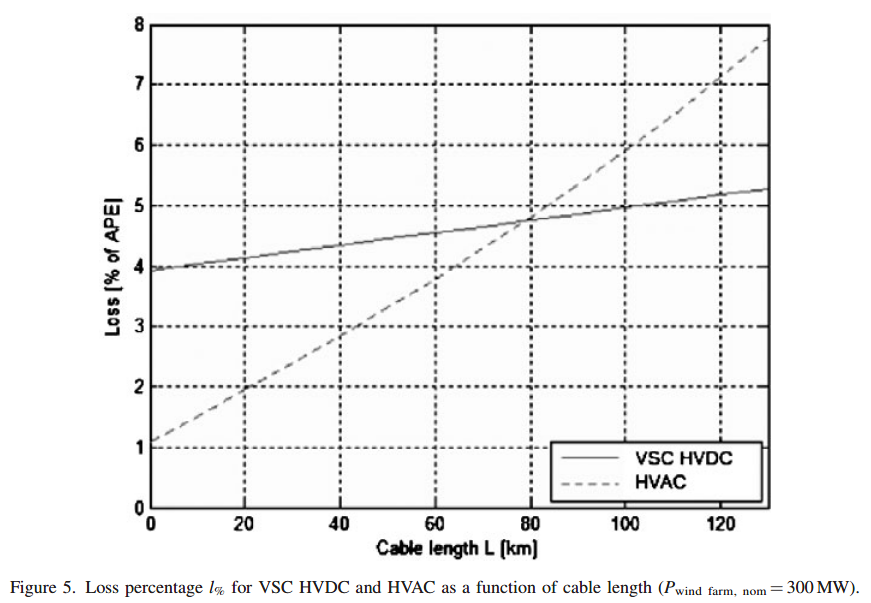

https://www.researchgate.net/publication/228055724_Economic_comparison_of_VSC_HVDC_and_HVAC_as_transmission_system_for_a_300MW_offshore_wind_farm

In [13]:
total_wind_energy_production = 3000 * 1000 * 4380 * 30 # parkcapacity * operational hours * operational lifecycle
print('total_wind_energy_production: {:.0f} kWh'.format(total_wind_energy_production))
energy_after_inter_array_cable_loss = 0.98 * total_wind_energy_production
print('energy_after_inter_array_cable_loss (20 km): {:.0f} kWh'.format(energy_after_inter_array_cable_loss))
energy_after_AC_collection_cable_loss = 0.98 * energy_after_inter_array_cable_loss
print('energy_after_AC_collection_cable_loss (20 km): {:.0f} kWh'.format(energy_after_AC_collection_cable_loss))

total_wind_energy_production: 394200000000 kWh
energy_after_inter_array_cable_loss (20 km): 386316000000 kWh
energy_after_AC_collection_cable_loss (20 km): 378589680000 kWh


In [14]:
total_energy = energy_after_AC_collection_cable_loss # kWh
total_cost = sum(data)            # EU

In [15]:
LCOE = total_cost / total_energy
print('LCOE: {:.2f} EU/kWh'.format(LCOE))

LCOE: 0.12 EU/kWh


In [16]:
# ToDo: also calculate efficiency (part of the originally produced energy that reaches the shore)
SupplyChain_efficiency = energy_after_AC_collection_cable_loss / total_wind_energy_production
print('SupplyChain efficiency: {} %'.format(SupplyChain_efficiency*100))

SupplyChain efficiency: 96.04 %


##### 7. real world visualisation

In [17]:
Turbine.geometry = shapely.geometry.Point([53.00714796349173, 3.885216307202442])
Foundation.geometry = shapely.geometry.Point([53.00714796349173, 3.885216307202442])

In [18]:
m = folium.Map(location=[52.66, 4.43], zoom_start=8)

folium.Marker(
    [Turbine.geometry.x, Turbine.geometry.y], 
    popup="<b>Turbine</b>", 
    tooltip="Click me!"
).add_to(m)

folium.Marker(
    [Foundation.geometry.x, Foundation.geometry.y], 
    popup="<b>Foundation</b>", 
    tooltip="Click me!"
).add_to(m)

cable_coordinates = [
   (53.00714796349173, 3.885216307202442), 
   (52.92142611240917, 4.1185675529709),
   (52.77719815259111, 4.263572751208232), 
   (52.64252638036501, 4.415540586993316), 
   (52.52697551717924, 4.60627767434106), 
]

folium.PolyLine(
    cable_coordinates, 
    tooltip="export cable"
).add_to(m)

m

# 